In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

from augmentation import apply_random_augmentations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
DATA_ROOT = Path('animal-clef-2025')
SPLITS_DIR = DATA_ROOT / 'splits'

EMBEDDING_DIM = 128
EPOCHS = 50
IMAGE_SIZE = 240

In [3]:
train_df = pd.read_csv(SPLITS_DIR / 'train.csv')
valid_seen_df = pd.read_csv(SPLITS_DIR / 'valid_seen.csv')
valid_unseen_df = pd.read_csv(SPLITS_DIR / 'valid_unseen.csv')
test_seen_df = pd.read_csv(SPLITS_DIR / 'test_seen.csv')
test_unseen_df = pd.read_csv(SPLITS_DIR / 'test_unseen.csv')

metadata_df = pd.read_csv(DATA_ROOT / 'metadata.csv')
query_df = metadata_df[metadata_df['split'] == 'query'].copy()

In [4]:
class TripletDataset(Dataset):
    def __init__(self, df, data_root, m, k, transform=None, augment=True):
        self.df = df
        self.data_root = Path(data_root)
        self.m = m
        self.k = k
        self.transform = transform
        self.augment = augment

        self.identity_to_indices = defaultdict(list)
        for idx, row in df.iterrows():
            self.identity_to_indices[row['identity']].append(idx)

        self.identities = list(self.identity_to_indices.keys())
        self.identity_to_label = {id_: i for i, id_ in enumerate(self.identities)}
        self.n_batches = len(self.identities) // m

        self.samples = []
        self.resample()

    def resample(self):
        self.samples = []
        shuffled_identities = np.random.permutation(self.identities)

        for batch_idx in range(self.n_batches):
            batch_identities = shuffled_identities[batch_idx * self.m:(batch_idx + 1) * self.m]

            for identity in batch_identities:
                indices = self.identity_to_indices[identity]

                if len(indices) >= self.k:
                    chosen = np.random.choice(indices, self.k, replace=False)
                else:
                    chosen = list(np.random.choice(indices, len(indices), replace=False))
                    extra = np.random.choice(indices, self.k - len(indices), replace=True)
                    chosen = chosen + list(extra)

                label = self.identity_to_label[identity]
                for img_idx in chosen:
                    self.samples.append((img_idx, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_idx, label = self.samples[idx]

        row = self.df.loc[img_idx]
        img_path = self.data_root / row['path']
        image = Image.open(img_path).convert('RGB')

        if self.augment:
            image = apply_random_augmentations(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
class SimpleDataset(Dataset):
    def __init__(self, df, data_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_root = Path(data_root)
        self.transform = transform
        
        self.identities = sorted(df['identity'].unique())
        self.identity_to_label = {id_: i for i, id_ in enumerate(self.identities)}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_root / row['path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.identity_to_label[row['identity']]
        identity = row['identity']
        
        return image, label, identity

In [6]:
class QueryDataset(Dataset):
    def __init__(self, df, data_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_root = Path(data_root)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_root / row['path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, row['image_id']

In [7]:
class EmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        efficientnet = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(efficientnet.children())[:-1])
        self.fc = nn.Linear(1280, embedding_dim)
    
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [8]:
class BatchHardTripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super().__init__()
        self.margin = margin
    
    def forward(self, embeddings, labels):
        pairwise_dist = torch.cdist(embeddings, embeddings, p=2)
        
        labels = labels.unsqueeze(0)
        mask_positive = (labels == labels.T).float()
        mask_negative = (labels != labels.T).float()
        
        mask_positive.fill_diagonal_(0)
        
        hardest_positive_dist = (pairwise_dist * mask_positive).max(dim=1)[0]
        
        max_dist = pairwise_dist.max()
        pairwise_dist_neg = pairwise_dist + max_dist * (1 - mask_negative)
        hardest_negative_dist = pairwise_dist_neg.min(dim=1)[0]
        
        triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)
        
        valid_triplets = (hardest_positive_dist > 0).float()
        loss = (triplet_loss * valid_triplets).sum() / (valid_triplets.sum() + 1e-8)
        
        return loss

In [9]:
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
train_eval_dataset = SimpleDataset(train_df, DATA_ROOT, transform=val_transform)
train_eval_loader = DataLoader(train_eval_dataset, batch_size=64, shuffle=False, num_workers=0)

valid_seen_dataset = SimpleDataset(valid_seen_df, DATA_ROOT, transform=val_transform)
valid_seen_loader = DataLoader(valid_seen_dataset, batch_size=64, shuffle=False, num_workers=0)

valid_unseen_dataset = SimpleDataset(valid_unseen_df, DATA_ROOT, transform=val_transform)
valid_unseen_loader = DataLoader(valid_unseen_dataset, batch_size=64, shuffle=False, num_workers=0)

test_seen_dataset = SimpleDataset(test_seen_df, DATA_ROOT, transform=val_transform)
test_seen_loader = DataLoader(test_seen_dataset, batch_size=64, shuffle=False, num_workers=0)

test_unseen_dataset = SimpleDataset(test_unseen_df, DATA_ROOT, transform=val_transform)
test_unseen_loader = DataLoader(test_unseen_dataset, batch_size=64, shuffle=False, num_workers=0)

query_dataset = QueryDataset(query_df, DATA_ROOT, transform=val_transform)
query_loader = DataLoader(query_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f'valid seen batches: {len(valid_seen_loader)}')
print(f'test seen batches: {len(test_seen_loader)}')
print(f'query batches: {len(query_loader)}')

valid seen batches: 19
test seen batches: 20
query batches: 34


In [11]:
def extract_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []
    identities = []
    
    with torch.no_grad():
        for images, lbls, ids in tqdm(loader, desc='extracting embeddings'):
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu())
            labels.extend(lbls.numpy())
            identities.extend(ids)
    
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings, np.array(labels), identities


def extract_query_embeddings(model, loader):
    model.eval()
    embeddings = []
    image_ids = []
    
    with torch.no_grad():
        for images, img_ids in tqdm(loader, desc='extracting query embeddings'):
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu())
            image_ids.extend(img_ids.numpy())
    
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings, image_ids

In [12]:
def compute_balanced_rank_k(query_emb, gallery_emb, query_ids, gallery_ids, k=1):
    dists = torch.cdist(query_emb, gallery_emb, p=2)
    _, indices = dists.topk(k, dim=1, largest=False)
    
    identity_correct = defaultdict(list)
    for i, idx in enumerate(indices):
        retrieved_ids = [gallery_ids[j] for j in idx.numpy()]
        correct = 1 if query_ids[i] in retrieved_ids else 0
        identity_correct[query_ids[i]].append(correct)
    
    per_identity_acc = []
    for identity, corrects in identity_correct.items():
        per_identity_acc.append(np.mean(corrects))
    
    return np.mean(per_identity_acc)

In [13]:
def evaluate_training(model, train_loader, valid_loader):
    train_emb, _, train_ids = extract_embeddings(model, train_loader)
    valid_emb, _, valid_ids = extract_embeddings(model, valid_loader)
    
    rank1 = compute_balanced_rank_k(valid_emb, train_emb, valid_ids, train_ids, k=1)
    rank5 = compute_balanced_rank_k(valid_emb, train_emb, valid_ids, train_ids, k=5)
    
    return rank1, rank5

In [14]:
import itertools

search_space = {
    'm': [4, 8],
    'k': [4, 8],
    'margin': [0.2, 0.3],
    'lr': [1e-4, 1e-3]
}

grid = list(itertools.product(
    search_space['m'], search_space['k'],
    search_space['margin'], search_space['lr']
))

best_score = 0
best_params = None
hp_epochs = 10

for i, (m, k, margin, lr) in enumerate(grid):
    print(f"config {i+1}/{len(grid)}: m={m}, k={k}, margin={margin}, lr={lr}")
    
    batch_size = m * k
    hp_train_dataset = TripletDataset(train_df, DATA_ROOT, m, k, transform=train_transform, augment=True)
    hp_train_loader = DataLoader(hp_train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    hp_model = EmbeddingModel(embedding_dim=EMBEDDING_DIM).to(device)
    hp_criterion = BatchHardTripletLoss(margin=margin)
    hp_optimizer = torch.optim.Adam(hp_model.parameters(), lr=lr)
    
    for epoch in range(hp_epochs):
        hp_train_dataset.resample()
        hp_model.train()
        for images, labels in hp_train_loader:
            images = images.to(device)
            labels = labels.to(device)
            hp_optimizer.zero_grad()
            embeddings = hp_model(images)
            loss = hp_criterion(embeddings, labels)
            loss.backward()
            hp_optimizer.step()
    
    rank1, rank5 = evaluate_training(hp_model, train_eval_loader, valid_seen_loader)
    print(f"  rank-1={rank1:.4f}, rank-5={rank5:.4f}")
    
    if rank1 > best_score:
        best_score = rank1
        best_params = {'m': m, 'k': k, 'margin': margin, 'lr': lr}

print(f"best params: {best_params}, rank-1={best_score:.4f}")

del hp_model, hp_criterion, hp_optimizer, hp_train_dataset, hp_train_loader
torch.cuda.empty_cache()

config 1/16: m=4, k=4, margin=0.2, lr=0.0001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:38<00:00,  2.05s/it]


  rank-1=0.3640, rank-5=0.4931
config 2/16: m=4, k=4, margin=0.2, lr=0.001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.05s/it]


  rank-1=0.2501, rank-5=0.3711
config 3/16: m=4, k=4, margin=0.3, lr=0.0001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.09s/it]


  rank-1=0.3773, rank-5=0.4848
config 4/16: m=4, k=4, margin=0.3, lr=0.001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


  rank-1=0.2171, rank-5=0.3461
config 5/16: m=4, k=8, margin=0.2, lr=0.0001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.05s/it]


  rank-1=0.3390, rank-5=0.4731
config 6/16: m=4, k=8, margin=0.2, lr=0.001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


  rank-1=0.2728, rank-5=0.4071
config 7/16: m=4, k=8, margin=0.3, lr=0.0001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


  rank-1=0.3644, rank-5=0.4848
config 8/16: m=4, k=8, margin=0.3, lr=0.001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


  rank-1=0.2539, rank-5=0.3981
config 9/16: m=8, k=4, margin=0.2, lr=0.0001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:21<00:00,  1.14s/it]


  rank-1=0.3476, rank-5=0.4691
config 10/16: m=8, k=4, margin=0.2, lr=0.001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.07s/it]


  rank-1=0.2670, rank-5=0.3933
config 11/16: m=8, k=4, margin=0.3, lr=0.0001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


  rank-1=0.3521, rank-5=0.4823
config 12/16: m=8, k=4, margin=0.3, lr=0.001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


  rank-1=0.2619, rank-5=0.3913
config 13/16: m=8, k=8, margin=0.2, lr=0.0001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.87s/it]


  rank-1=0.3079, rank-5=0.4416
config 14/16: m=8, k=8, margin=0.2, lr=0.001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:35<00:00,  1.89s/it]


  rank-1=0.3056, rank-5=0.4385
config 15/16: m=8, k=8, margin=0.3, lr=0.0001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:32<00:00,  1.69s/it]


  rank-1=0.3310, rank-5=0.4699
config 16/16: m=8, k=8, margin=0.3, lr=0.001


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:36<00:00,  1.91s/it]


  rank-1=0.2810, rank-5=0.4077
best params: {'m': 4, 'k': 4, 'margin': 0.3, 'lr': 0.0001}, rank-1=0.3773


In [15]:
M = best_params['m']
K = best_params['k']
MARGIN = best_params['margin']
LR = best_params['lr']
BATCH_SIZE = M * K

train_dataset = TripletDataset(train_df, DATA_ROOT, M, K, transform=train_transform, augment=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = EmbeddingModel(embedding_dim=EMBEDDING_DIM).to(device)
criterion = BatchHardTripletLoss(margin=MARGIN)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(f"training with m={M}, k={K}, margin={MARGIN}, lr={LR}")

training with m=4, k=4, margin=0.3, lr=0.0001


In [16]:
history = {
    'train_loss': [],
    'valid_balanced_rank1': [],
    'valid_balanced_rank5': []
}

for epoch in range(EPOCHS):
    train_dataset.resample()

    model.train()
    epoch_loss = 0
    n_batches = 0

    pbar = tqdm(train_loader, desc=f'epoch {epoch+1}/{EPOCHS}')
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        loss = criterion(embeddings, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1
        pbar.set_postfix({'loss': epoch_loss / n_batches})

    avg_loss = epoch_loss / n_batches
    history['train_loss'].append(avg_loss)

    rank1, rank5 = evaluate_training(model, train_eval_loader, valid_seen_loader)
    history['valid_balanced_rank1'].append(rank1)
    history['valid_balanced_rank5'].append(rank5)

    print(f'epoch {epoch+1}: loss={avg_loss:.4f}, balanced rank-1={rank1:.4f}, balanced rank-5={rank5:.4f}')

extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:39<00:00,  2.08s/it]


epoch 1: loss=0.3281, balanced rank-1=0.2210, balanced rank-5=0.3455


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 2: loss=0.3000, balanced rank-1=0.2384, balanced rank-5=0.3697


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 3: loss=0.2863, balanced rank-1=0.2916, balanced rank-5=0.4094


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 4: loss=0.2579, balanced rank-1=0.2892, balanced rank-5=0.4323


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 5: loss=0.2619, balanced rank-1=0.3132, balanced rank-5=0.4367


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.07s/it]


epoch 6: loss=0.2509, balanced rank-1=0.3294, balanced rank-5=0.4488


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


epoch 7: loss=0.2476, balanced rank-1=0.3210, balanced rank-5=0.4905


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 8: loss=0.2354, balanced rank-1=0.3391, balanced rank-5=0.4773


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 9: loss=0.2346, balanced rank-1=0.3667, balanced rank-5=0.4897


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 10: loss=0.2287, balanced rank-1=0.3625, balanced rank-5=0.5021


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


epoch 11: loss=0.2296, balanced rank-1=0.3730, balanced rank-5=0.5218


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.05s/it]


epoch 12: loss=0.2189, balanced rank-1=0.3840, balanced rank-5=0.5122


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 13: loss=0.2184, balanced rank-1=0.3903, balanced rank-5=0.5179


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 14: loss=0.2141, balanced rank-1=0.3855, balanced rank-5=0.5138


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 15: loss=0.2105, balanced rank-1=0.4034, balanced rank-5=0.5375


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 16: loss=0.2081, balanced rank-1=0.3978, balanced rank-5=0.5417


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 17: loss=0.2035, balanced rank-1=0.4085, balanced rank-5=0.5351


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 18: loss=0.2026, balanced rank-1=0.4106, balanced rank-5=0.5556


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 19: loss=0.2061, balanced rank-1=0.4080, balanced rank-5=0.5497


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 20: loss=0.1929, balanced rank-1=0.4224, balanced rank-5=0.5484


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.05s/it]


epoch 21: loss=0.1953, balanced rank-1=0.4295, balanced rank-5=0.5390


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 22: loss=0.1849, balanced rank-1=0.4267, balanced rank-5=0.5503


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 23: loss=0.1843, balanced rank-1=0.4313, balanced rank-5=0.5501


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.05s/it]


epoch 24: loss=0.1890, balanced rank-1=0.4217, balanced rank-5=0.5423


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 25: loss=0.1809, balanced rank-1=0.4384, balanced rank-5=0.5509


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


epoch 26: loss=0.1780, balanced rank-1=0.4371, balanced rank-5=0.5564


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 27: loss=0.1822, balanced rank-1=0.4318, balanced rank-5=0.5570


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 28: loss=0.1686, balanced rank-1=0.4379, balanced rank-5=0.5650


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 29: loss=0.1773, balanced rank-1=0.4451, balanced rank-5=0.5621


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.09s/it]


epoch 30: loss=0.1668, balanced rank-1=0.4424, balanced rank-5=0.5505


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.09s/it]


epoch 31: loss=0.1699, balanced rank-1=0.4337, balanced rank-5=0.5634


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


epoch 32: loss=0.1733, balanced rank-1=0.4384, balanced rank-5=0.5587


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


epoch 33: loss=0.1792, balanced rank-1=0.4561, balanced rank-5=0.5868


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


epoch 34: loss=0.1623, balanced rank-1=0.4479, balanced rank-5=0.5784


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


epoch 35: loss=0.1443, balanced rank-1=0.4516, balanced rank-5=0.5687


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.07s/it]


epoch 36: loss=0.1646, balanced rank-1=0.4531, balanced rank-5=0.5663


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 37: loss=0.1572, balanced rank-1=0.4608, balanced rank-5=0.5646


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.05s/it]


epoch 38: loss=0.1479, balanced rank-1=0.4502, balanced rank-5=0.5567


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 39: loss=0.1608, balanced rank-1=0.4381, balanced rank-5=0.5528


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


epoch 40: loss=0.1593, balanced rank-1=0.4218, balanced rank-5=0.5536


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.05s/it]


epoch 41: loss=0.1462, balanced rank-1=0.4367, balanced rank-5=0.5573


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 42: loss=0.1532, balanced rank-1=0.4520, balanced rank-5=0.5729


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


epoch 43: loss=0.1520, balanced rank-1=0.4546, balanced rank-5=0.5626


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 44: loss=0.1435, balanced rank-1=0.4383, balanced rank-5=0.5555


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


epoch 45: loss=0.1493, balanced rank-1=0.4428, balanced rank-5=0.5623


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 46: loss=0.1540, balanced rank-1=0.4524, balanced rank-5=0.5708


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


epoch 47: loss=0.1376, balanced rank-1=0.4563, balanced rank-5=0.5743


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


epoch 48: loss=0.1376, balanced rank-1=0.4514, balanced rank-5=0.5868


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


epoch 49: loss=0.1445, balanced rank-1=0.4476, balanced rank-5=0.5739


extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


epoch 50: loss=0.1359, balanced rank-1=0.4519, balanced rank-5=0.5879


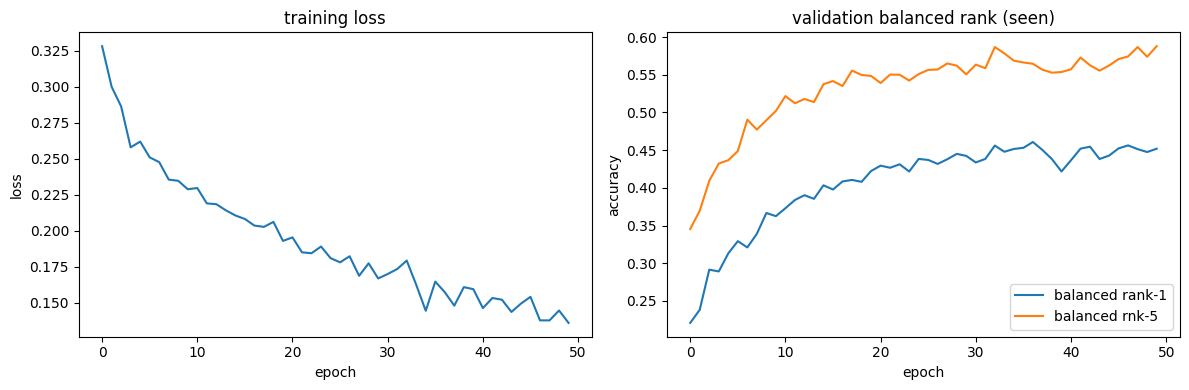

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].set_title('training loss')

axes[1].plot(history['valid_balanced_rank1'], label='balanced rank-1')
axes[1].plot(history['valid_balanced_rank5'], label='balanced rnk-5')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].set_title('validation balanced rank (seen)')
axes[1].legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

In [18]:
train_emb, _, train_ids = extract_embeddings(model, train_eval_loader)
valid_seen_emb, _, valid_seen_ids = extract_embeddings(model, valid_seen_loader)
valid_unseen_emb, _, valid_unseen_ids = extract_embeddings(model, valid_unseen_loader)

train_id_to_emb = defaultdict(list)
for emb, id_ in zip(train_emb, train_ids):
    train_id_to_emb[id_].append(emb)

train_centroids = {}
for id_, embs in train_id_to_emb.items():
    centroid = torch.stack(embs).mean(dim=0)
    centroid = F.normalize(centroid, p=2, dim=0)
    train_centroids[id_] = centroid

centroid_ids = list(train_centroids.keys())
centroid_emb = torch.stack([train_centroids[id_] for id_ in centroid_ids])

extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:35<00:00,  2.56s/it]


In [19]:
def get_min_distances_and_predictions(query_emb, gallery_emb, centroid_ids):
    dists = torch.cdist(query_emb, gallery_emb, p=2)
    min_dists, min_idx = dists.min(dim=1)
    predicted_ids = [centroid_ids[i] for i in min_idx.numpy()]
    return min_dists.numpy(), predicted_ids

seen_min_dists, seen_pred_ids = get_min_distances_and_predictions(valid_seen_emb, centroid_emb, centroid_ids)
unseen_min_dists, _ = get_min_distances_and_predictions(valid_unseen_emb, centroid_emb, centroid_ids)

In [20]:
def compute_baks(true_ids, pred_ids, dists, threshold):
    identity_correct = defaultdict(list)
    for true_id, pred_id, dist in zip(true_ids, pred_ids, dists):
        if dist < threshold and true_id == pred_id:
            identity_correct[true_id].append(1)
        else:
            identity_correct[true_id].append(0)
    
    per_identity_acc = [np.mean(corrects) for corrects in identity_correct.values()]
    return np.mean(per_identity_acc)


def compute_baus(dists, ids, threshold):
    is_unseen_pred = dists >= threshold
    identity_correct = defaultdict(list)
    for id_, is_unseen in zip(ids, is_unseen_pred):
        identity_correct[id_].append(1 if is_unseen else 0)
    
    per_identity_acc = [np.mean(v) for v in identity_correct.values()]
    return np.mean(per_identity_acc)

In [21]:
all_dists = np.concatenate([seen_min_dists, unseen_min_dists])
thresholds = np.linspace(all_dists.min(), all_dists.max(), 100)

best_threshold = 0
best_score = 0

for thresh in thresholds:
    baks = compute_baks(valid_seen_ids, seen_pred_ids, seen_min_dists, thresh)
    baus = compute_baus(unseen_min_dists, valid_unseen_ids, thresh)
    
    if baks > 0 and baus > 0:
        harmonic = 2 * baks * baus / (baks + baus)
    else:
        harmonic = 0
    
    if harmonic > best_score:
        best_score = harmonic
        best_threshold = thresh

print(f'best threshold= {best_threshold:.4f} harmonic mean={best_score:.4f}')

best threshold= 0.5111 harmonic mean=0.3202


In [22]:
test_seen_emb, _, test_seen_ids = extract_embeddings(model, test_seen_loader)
test_unseen_emb, _, test_unseen_ids = extract_embeddings(model, test_unseen_loader)

extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it]


In [23]:
test_seen_dists, test_seen_pred_ids = get_min_distances_and_predictions(test_seen_emb, centroid_emb, centroid_ids)
test_unseen_dists, _ = get_min_distances_and_predictions(test_unseen_emb, centroid_emb, centroid_ids)

balanced_rank5 = compute_balanced_rank_k(test_seen_emb, train_emb, test_seen_ids, train_ids, k=5)
baks = compute_baks(test_seen_ids, test_seen_pred_ids, test_seen_dists, best_threshold)
baus = compute_baus(test_unseen_dists, test_unseen_ids, best_threshold)

print('final metrics on test set:')
print(f'threshold: {best_threshold:.4f}')
print(f'balanced rank-5 (known): {balanced_rank5:.4f}')
print(f'baks (balanced accuracy on known samples): {baks:.4f}')
print(f'baus (balanced accuracy on unknown samples): {baus:.4f}')
print(f'test known: {len(test_seen_ids)} images, {len(set(test_seen_ids))} identities')
print(f'test unknown: {len(test_unseen_ids)} images, {len(set(test_unseen_ids))} identities')

final metrics on test set:
threshold: 0.5111
balanced rank-5 (known): 0.5546
baks (balanced accuracy on known samples): 0.2352
baus (balanced accuracy on unknown samples): 0.4223
test known: 1273 images, 705 identities
test unknown: 592 images, 199 identities


In [26]:
all_seen_df = pd.concat([train_df, valid_seen_df, test_seen_df], ignore_index=True)
all_seen_dataset = SimpleDataset(all_seen_df, DATA_ROOT, transform=val_transform)
all_seen_loader = DataLoader(all_seen_dataset, batch_size=64, shuffle=False, num_workers=0)

all_seen_emb, _, all_seen_ids = extract_embeddings(model, all_seen_loader)

all_id_to_emb = defaultdict(list)
for emb, id_ in zip(all_seen_emb, all_seen_ids):
    all_id_to_emb[id_].append(emb)

all_centroids = {}
for id_, embs in all_id_to_emb.items():
    centroid = torch.stack(embs).mean(dim=0)
    centroid = F.normalize(centroid, p=2, dim=0)
    all_centroids[id_] = centroid

all_centroid_ids = list(all_centroids.keys())
all_centroid_emb = torch.stack([all_centroids[id_] for id_ in all_centroid_ids])

print(f'gallery: {len(all_seen_df)} images, {len(all_centroid_ids)} identities')

query_emb, query_image_ids = extract_query_embeddings(model, query_loader)

query_dists, query_pred_ids = get_min_distances_and_predictions(query_emb, all_centroid_emb, all_centroid_ids)
query_is_seen = query_dists < best_threshold

predictions = []
for img_id, pred_id, is_seen in zip(query_image_ids, query_pred_ids, query_is_seen):
    if is_seen:
        predictions.append({'image_id': img_id, 'identity': pred_id})
    else:
        predictions.append({'image_id': img_id, 'identity': 'new_individual'})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values('image_id')
submission_df.to_csv('submission.csv', index=False)

extracting embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [04:02<00:00,  1.34s/it]


gallery: 11632 images, 705 identities


extracting query embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 34/34 [01:25<00:00,  2.50s/it]


In [25]:
torch.save({
    'model_state_dict': model.state_dict(),
    'threshold': best_threshold,
    'centroid_ids': centroid_ids,
    'centroid_emb': centroid_emb,
    'history': history,
    'test_metrics': {
        'balanced_rank5': balanced_rank5,
        'baks': baks,
        'baus': baus
    }
}, 'model_checkpoint.pt')